In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import os
import numpy as np
import pandas as pd
import anndata as ad 
import squidpy as sq
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sb
import scvi 
import torch #pytorch
import runpy
import pickle
from datetime import datetime
import celltypist
from celltypist import models

from os import sys
sys.path.append('/tmp/work/Visium/BRCA_2024/brca_scripts')
from visiumPipeline import processVisium
from applyCosineScores import cosineScores
from tumorSegmentation import retrieveTumorMask
from getRSigs import getRSigs
from py_AUCell import AUCell

sc.set_figure_params(figsize=(4,4))
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3

#gettting model for celltypist
models.download_models(force_update = True)
model = models.Model.load(model = 'Immune_All_High.pkl')

#define sample poths, sample names and emptry dictionary

samples = ['2018838/PRE-01','2018838/PRE-02','2018838/POST-03','2018838/POST-05',
           '2018839/PRE-04','2018839/PRE-05','2018839/POST-06','2018839/POST-11']

# create pseudobulk profile
result = runpy.run_path('/tmp/work/Visium/BRCA_2024/brca_scripts/acquirePseudoBulkRef.py')
# read pseudobulk to variable
pb_df = pd.read_pickle('wu_2021_pseudobulk.pkl')

#grab the gene signatures
signatures_dict, signature_groups_list = getRSigs()

#prepare a list of paths for hires images required for tumor segmentation
image_paths = []
for sample in samples:
    image_path = '/tmp/work/Visium/' + sample + '/spatial/tissue_hires_image.png'
    image_paths.append(image_path)
    
sample_names = [os.path.basename(sample) for sample in samples]
visium_samples = variables = {name: None for name in sample_names} #variable names associated with emptry values in dictionary for storing data later

/opt/conda/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/scvi/__init__.py:31: DeprecationWarning: scvi is deprecated, please uninstall scvi via `pip uninstall scvi` and install the new scvi-tools package at github.com/YosefLab/scvi-tools
  warnings.warn(deprecation_msg, DeprecationWarning)
cffi mode is CFFI_MODE.ANY
R home found: /opt/conda/lib/R
R library path: 
LD_LIBRARY_PATH: 
Default options to initialize R: rpy2, --quiet, --no-save
R is already initialized. No need to initialize.
/opt/conda/lib/python3.10/site-packages/scanpy/_setting

normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50


2024-08-21 14:29:01.308648: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:24)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:04)
normalizing counts per cell
    finished (0:00:00)


/opt/conda/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/opt/conda/lib/python3.10/site-packages/rpy2/robjects/numpy2ri.py:241: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '


In [3]:
#process each of the samples

start_time = datetime.now()

for i in range(len(samples)):
    print('\n')
    print('Initial Processing of:'+sample_names[i])
    print('\n')
    visium_samples[sample_names[i]] = processVisium(samples[i],model)
    print('\n')
    print('Applying cosine similiarities for:'+sample_names[i])
    print('\n')
    visium_samples[sample_names[i]] = cosineScores(visium_samples[sample_names[i]],pb_df)  # apply cosine similarites
    print('\n')
    print('Subsetting morphology for:'+sample_names[i])
    print('\n')
    visium_samples[sample_names[i]] = retrieveTumorMask(image_paths[i],visium_samples[sample_names[i]])  # tumor segmentation
    print('\n')
    print('Applying gene signatures scores for:'+sample_names[i])
    print('\n')
    visium_samples[sample_names[i]] = AUCell(visium_samples[sample_names[i]],signatures_dict,signature_groups_list)  #apply gene signatures scores
    
end_time = datetime.now()
execution_time = end_time - start_time
print('\n')
print(f"Execution time: {execution_time}")

#save the file for later use
with open('visium_samples.pkl', 'wb') as file:
    pickle.dump(visium_samples, file)



Initial Processing of:PRE-01


/tmp/work/Visium/2018838/PRE-01
reading /tmp/work/Visium/2018838/PRE-01/filtered_feature_bc_matrix.h5
 (0:00:01)
filtered out 60 cells that have less than 1000 counts
filtered out 45 genes that are detected in less than 5 cells
normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obs

🔬 Input data has 4668 cells and 18040 genes
🔗 Matching reference genes in the model
🧬 5047 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5


running Leiden clustering
    finished: found 53 clusters and added
    'over_clustering', the cluster labels (adata.obs, categorical) (0:00:00)


🗳️ Majority voting the predictions
✅ Majority voting done!




Applying cosine similiarities for:PRE-01


Valid columns: 905
Missing columns: 95


Subsetting morphology for:PRE-01


Shape of RGB image array: (1964, 2000, 3)
Corrected shape of RGB image array: (1964, 2000, 3)


Applying gene signatures scores for:PRE-01




Initial Processing of:PRE-02


/tmp/work/Visium/2018838/PRE-02
reading /tmp/work/Visium/2018838/PRE-02/filtered_feature_bc_matrix.h5
 (0:00:01)
filtered out 98 cells that have less than 1000 counts
filtered out 58 genes that are detected in less than 5 cells
normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' wit

🔬 Input data has 4894 cells and 18027 genes
🔗 Matching reference genes in the model
🧬 5047 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5


running Leiden clustering
    finished: found 60 clusters and added
    'over_clustering', the cluster labels (adata.obs, categorical) (0:00:00)


🗳️ Majority voting the predictions
✅ Majority voting done!




Applying cosine similiarities for:PRE-02


Valid columns: 935
Missing columns: 65


Subsetting morphology for:PRE-02


Shape of RGB image array: (2000, 1981, 3)
Corrected shape of RGB image array: (2000, 1981, 3)


Applying gene signatures scores for:PRE-02




Initial Processing of:POST-03


/tmp/work/Visium/2018838/POST-03
reading /tmp/work/Visium/2018838/POST-03/filtered_feature_bc_matrix.h5
 (0:00:00)
filtered out 1453 cells that have less than 1000 counts
filtered out 56 genes that are detected in less than 5 cells
normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca

🔬 Input data has 3539 cells and 18029 genes
🔗 Matching reference genes in the model
🧬 5047 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5


running Leiden clustering
    finished: found 58 clusters and added
    'over_clustering', the cluster labels (adata.obs, categorical) (0:00:00)


🗳️ Majority voting the predictions
✅ Majority voting done!




Applying cosine similiarities for:POST-03


Valid columns: 904
Missing columns: 96


Subsetting morphology for:POST-03


Shape of RGB image array: (2000, 1950, 3)
Corrected shape of RGB image array: (2000, 1950, 3)


Applying gene signatures scores for:POST-03




Initial Processing of:POST-05


/tmp/work/Visium/2018838/POST-05
reading /tmp/work/Visium/2018838/POST-05/filtered_feature_bc_matrix.h5
 (0:00:00)
filtered out 79 cells that have less than 1000 counts
filtered out 53 genes that are detected in less than 5 cells
normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pc

🔬 Input data has 4644 cells and 18032 genes
🔗 Matching reference genes in the model
🧬 5045 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5


running Leiden clustering
    finished: found 53 clusters and added
    'over_clustering', the cluster labels (adata.obs, categorical) (0:00:00)


🗳️ Majority voting the predictions
✅ Majority voting done!




Applying cosine similiarities for:POST-05


Valid columns: 898
Missing columns: 102


Subsetting morphology for:POST-05


Shape of RGB image array: (1989, 2000, 3)
Corrected shape of RGB image array: (1989, 2000, 3)


Applying gene signatures scores for:POST-05




Initial Processing of:PRE-04


/tmp/work/Visium/2018839/PRE-04
reading /tmp/work/Visium/2018839/PRE-04/filtered_feature_bc_matrix.h5
 (0:00:01)
filtered out 33 cells that have less than 1000 counts
filtered out 58 genes that are detected in less than 5 cells
normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca'

🔬 Input data has 4749 cells and 18027 genes
🔗 Matching reference genes in the model
🧬 5048 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5


running Leiden clustering
    finished: found 59 clusters and added
    'over_clustering', the cluster labels (adata.obs, categorical) (0:00:00)


🗳️ Majority voting the predictions
✅ Majority voting done!




Applying cosine similiarities for:PRE-04


Valid columns: 902
Missing columns: 98


Subsetting morphology for:PRE-04


Shape of RGB image array: (2000, 1940, 3)
Corrected shape of RGB image array: (2000, 1940, 3)


Applying gene signatures scores for:PRE-04




Initial Processing of:PRE-05


/tmp/work/Visium/2018839/PRE-05
reading /tmp/work/Visium/2018839/PRE-05/filtered_feature_bc_matrix.h5
 (0:00:01)
filtered out 87 cells that have less than 1000 counts
filtered out 56 genes that are detected in less than 5 cells
normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' wit

🔬 Input data has 4777 cells and 18029 genes
🔗 Matching reference genes in the model
🧬 5048 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5


running Leiden clustering
    finished: found 53 clusters and added
    'over_clustering', the cluster labels (adata.obs, categorical) (0:00:00)


🗳️ Majority voting the predictions
✅ Majority voting done!




Applying cosine similiarities for:PRE-05


Valid columns: 926
Missing columns: 74


Subsetting morphology for:PRE-05


Shape of RGB image array: (1949, 2000, 3)
Corrected shape of RGB image array: (1949, 2000, 3)


Applying gene signatures scores for:PRE-05




Initial Processing of:POST-06


/tmp/work/Visium/2018839/POST-06
reading /tmp/work/Visium/2018839/POST-06/filtered_feature_bc_matrix.h5
 (0:00:01)
filtered out 15 cells that have less than 1000 counts
filtered out 46 genes that are detected in less than 5 cells
normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' 

🔬 Input data has 4701 cells and 18039 genes
🔗 Matching reference genes in the model
🧬 5044 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5


running Leiden clustering
    finished: found 59 clusters and added
    'over_clustering', the cluster labels (adata.obs, categorical) (0:00:00)


🗳️ Majority voting the predictions
✅ Majority voting done!




Applying cosine similiarities for:POST-06


Valid columns: 895
Missing columns: 105


Subsetting morphology for:POST-06


Shape of RGB image array: (2000, 1935, 3)
Corrected shape of RGB image array: (2000, 1935, 3)


Applying gene signatures scores for:POST-06




Initial Processing of:POST-11


/tmp/work/Visium/2018839/POST-11
reading /tmp/work/Visium/2018839/POST-11/filtered_feature_bc_matrix.h5
 (0:00:00)
filtered out 1500 cells that have less than 1000 counts
filtered out 72 genes that are detected in less than 5 cells
normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X

🔬 Input data has 3137 cells and 18013 genes
🔗 Matching reference genes in the model
🧬 5045 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5


running Leiden clustering
    finished: found 62 clusters and added
    'over_clustering', the cluster labels (adata.obs, categorical) (0:00:00)


🗳️ Majority voting the predictions
✅ Majority voting done!




Applying cosine similiarities for:POST-11


Valid columns: 902
Missing columns: 98


Subsetting morphology for:POST-11


Shape of RGB image array: (2000, 1941, 3)
Corrected shape of RGB image array: (2000, 1941, 3)


Applying gene signatures scores for:POST-11




Execution time: 0:04:30.034470


In [4]:
with open('visium_samples.pkl', 'rb') as file:
    visium_samples = pickle.load(file)

In [5]:
# All possible categories
cell_type_categories = ['Epithelial cells', 'Endothelial cells', 'Fibroblasts', 'B cells', 'Plasma cells', 'Macrophages','pDC']

# Initialize an empty DataFrame to store the results
combined_df = pd.DataFrame(index=cell_type_categories)

# Loop over each dataset
for sample in sample_names:
    # Create the frequency table and normalize it to relative frequencies
    current_data_set = visium_samples[sample]
    current_counts = current_data_set.obs['majority_voting']
    frequency_table = current_counts.value_counts().reindex(cell_type_categories, fill_value=0)
    relative_frequencies = frequency_table / frequency_table.sum()
    combined_df[sample] = relative_frequencies

print(combined_df)

simple_cateogories = {'epi':combined_df.iloc[0:1,:].sum(axis = 0),
            'all_others':combined_df.iloc[1:,:].sum(axis = 0)}
simple_df = pd.DataFrame(data=simple_cateogories)
simple_df = simple_df.transpose()

print(simple_df)

                     PRE-01    PRE-02   POST-03   POST-05    PRE-04    PRE-05  \
Epithelial cells   0.816497  0.922901  0.956143  0.834751  0.746096  0.870127   
Endothelial cells  0.045412  0.005326  0.021761  0.091130  0.032678  0.000506   
Fibroblasts        0.084801  0.000000  0.000000  0.074119  0.120012  0.075696   
B cells            0.020853  0.000000  0.000000  0.000000  0.027183  0.011392   
Plasma cells       0.032437  0.058838  0.022096  0.000000  0.074031  0.042278   
Macrophages        0.000000  0.012934  0.000000  0.000000  0.000000  0.000000   
pDC                0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

                    POST-06   POST-11  
Epithelial cells   0.569508  0.383495  
Endothelial cells  0.025875  0.134304  
Fibroblasts        0.012430  0.456311  
B cells            0.003805  0.024272  
Plasma cells       0.303146  0.000000  
Macrophages        0.045408  0.001618  
pDC                0.039827  0.000000  
              PRE-01    PRE-02 

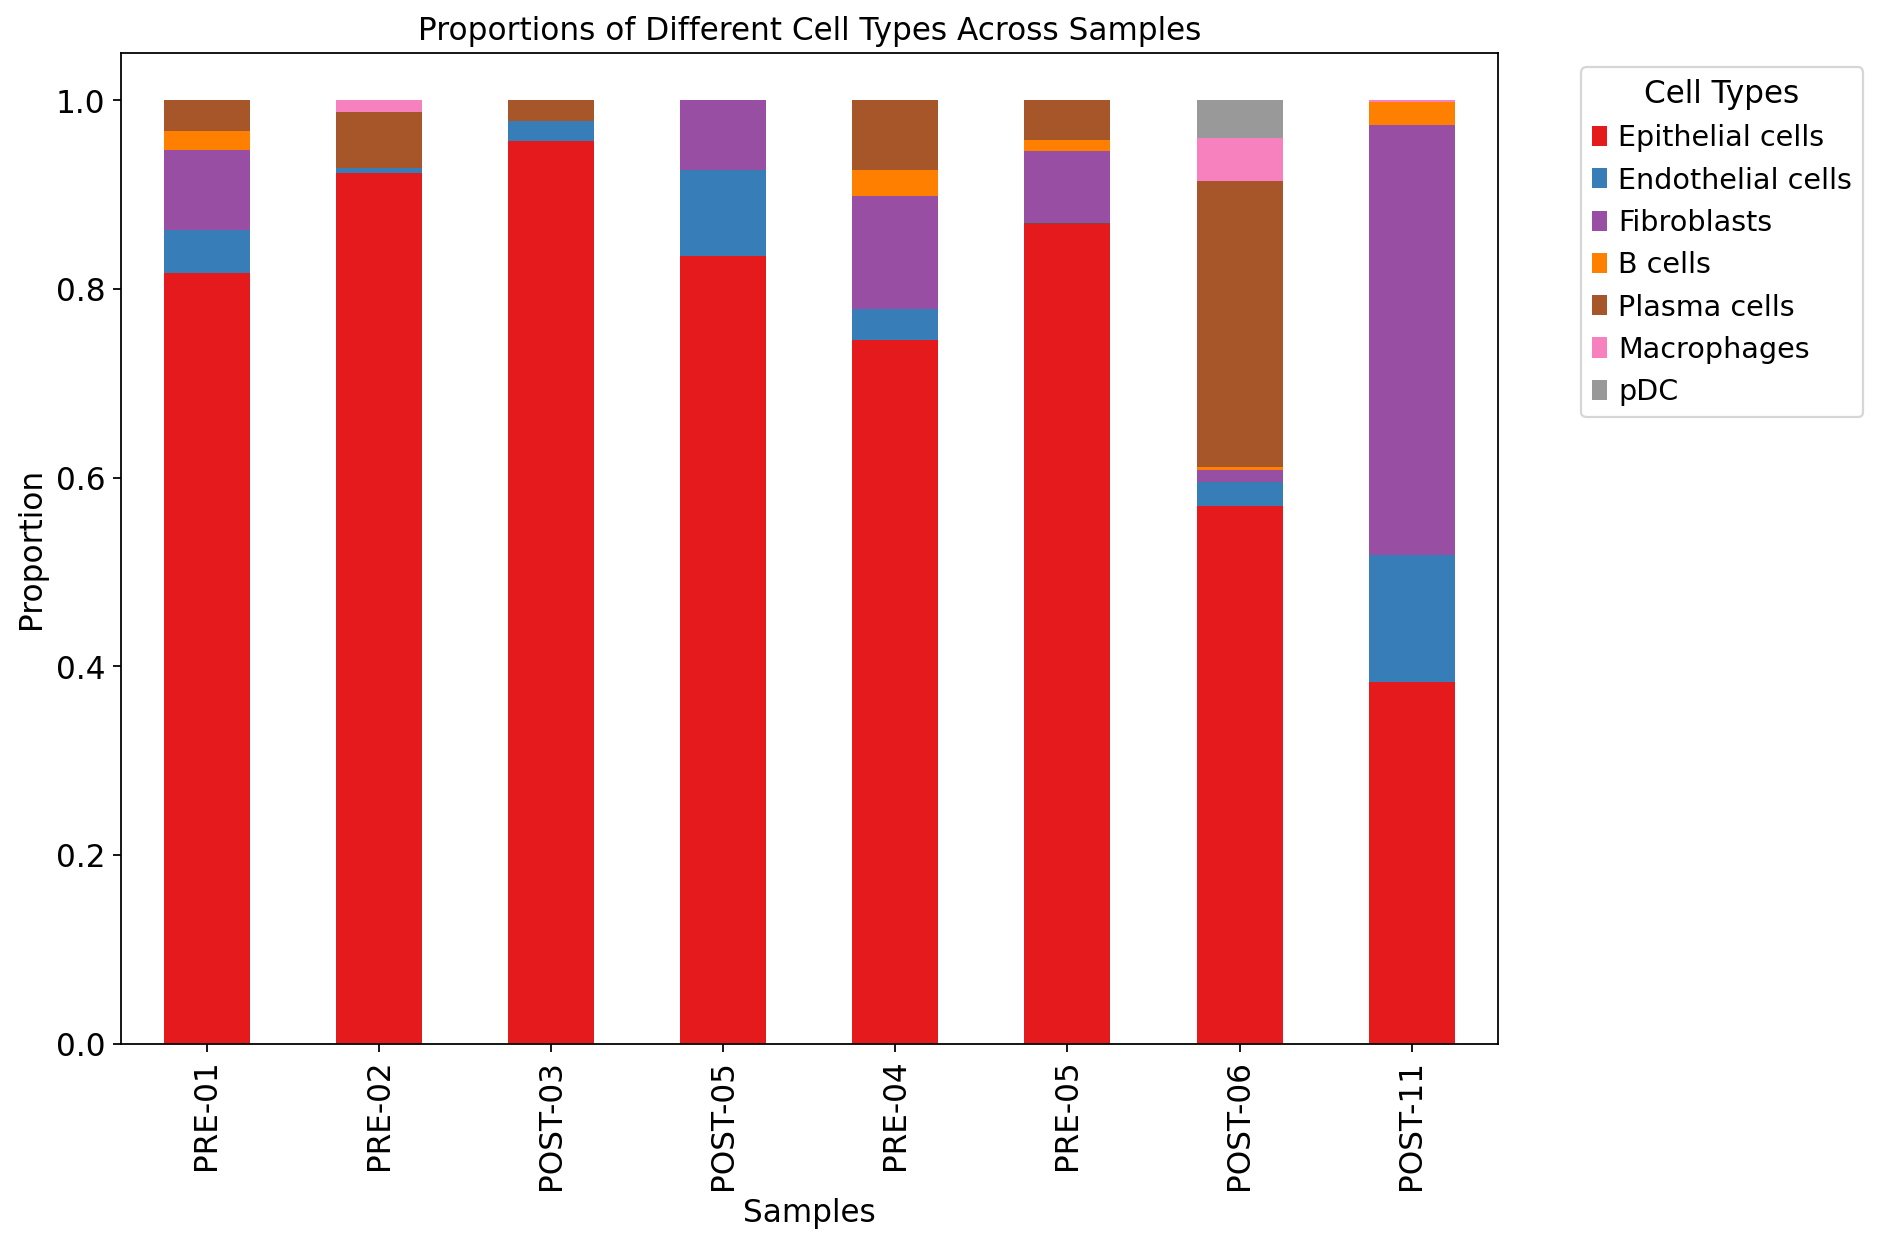

In [6]:
# Plotting the stacked bar graph
ax = combined_df.T.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='Set1')  # Higher contrast color map

# Remove grid lines
plt.grid(False)

# Adding title and labels
plt.title('Proportions of Different Cell Types Across Samples')
plt.xlabel('Samples')
plt.ylabel('Proportion')
plt.legend(title='Cell Types', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to make room for the legend
plt.tight_layout()

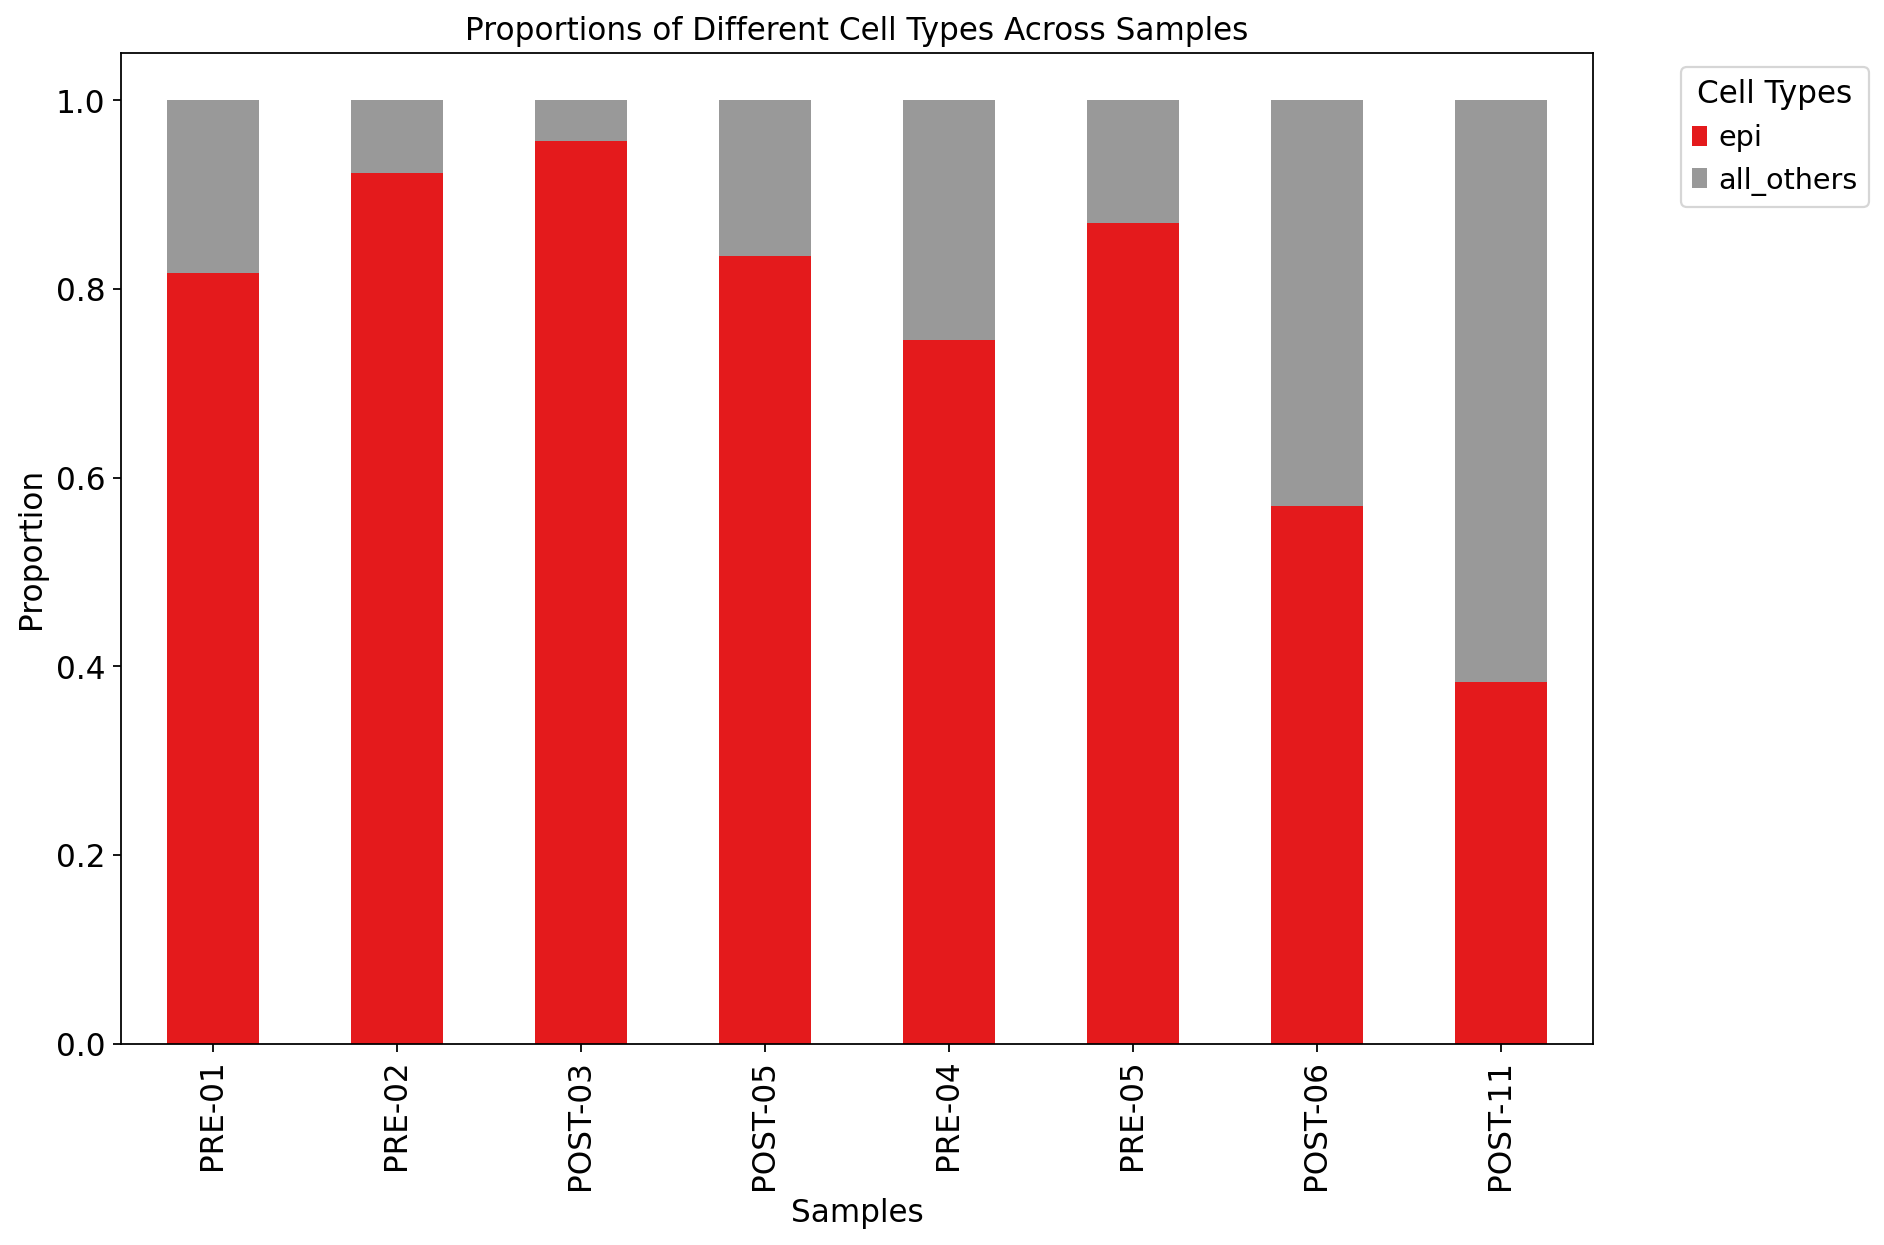

In [7]:
# Plotting the stacked bar graph
ax = simple_df.T.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='Set1')  # Higher contrast color map

# Remove grid lines
plt.grid(False)

# Adding title and labels
plt.title('Proportions of Different Cell Types Across Samples')
plt.xlabel('Samples')
plt.ylabel('Proportion')
plt.legend(title='Cell Types', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to make room for the legend
plt.tight_layout()

In [8]:
# setup a dataframe for the heatmap plot

simple_df = pd.DataFrame(data=simple_cateogories)

signature_scores_df = pd.DataFrame(columns=signature_groups_list, index = sample_names)

for sample in sample_names:
    current_data = visium_samples[sample]
    for signature in signature_groups_list:
        signature_scores_df.at[sample, signature] = np.mean(current_data.obs[signature])

column_values = simple_df['all_others']
immune_invasiveness_ascending = column_values.sort_values(ascending=True).index.tolist()
signature_scores_df = signature_scores_df.loc[immune_invasiveness_ascending]


In [19]:
from scipy.stats import zscore

signature_scores_df = signature_scores_df.apply(pd.to_numeric, errors='coerce')
signature_scores_df_z = signature_scores_df.apply(zscore)
signature_scores_df_z = signature_scores_df_z.drop('Goff_Cell proliferation', axis=1)
signature_scores_df_z = signature_scores_df_z.drop('Goff_Myeloid inflammatory', axis=1)
signature_scores_df_z = signature_scores_df_z.drop('Goff_B cells', axis=1)
signature_scores_df_z = signature_scores_df_z.drop('Goff_NK cells', axis=1)




<Figure size 800x480 with 0 Axes>

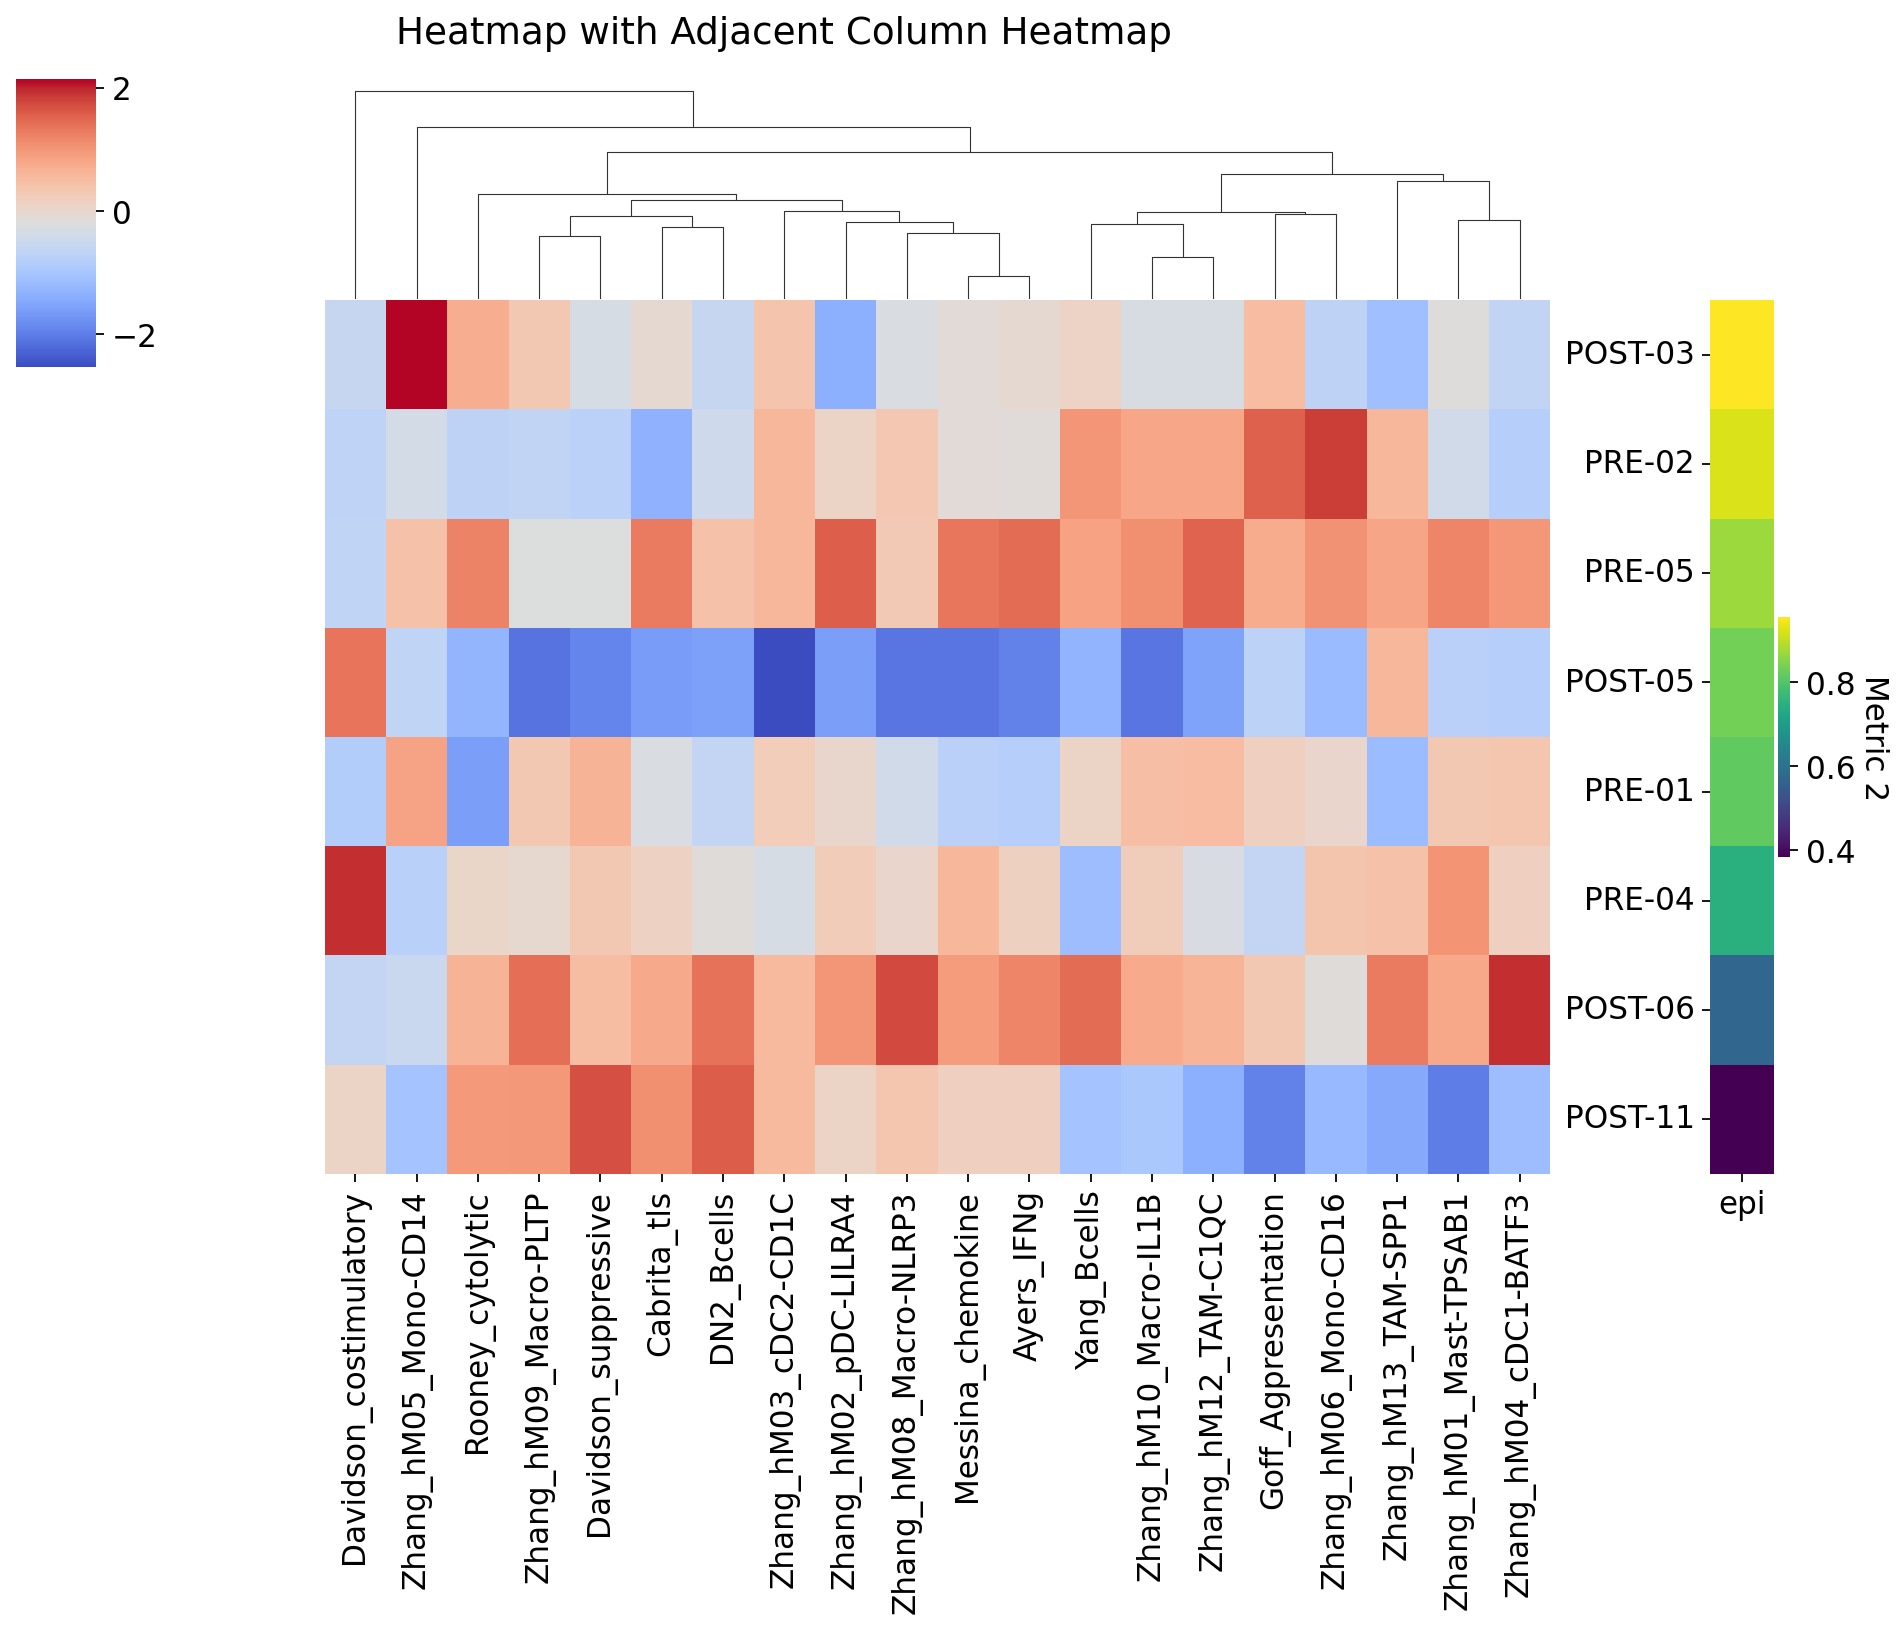

In [20]:
import matplotlib.pyplot as plt
import seaborn as sb

# Create the primary heatmap using clustermap
plt.figure(figsize=(10, 6))  # Increase figure width to accommodate both heatmaps
clusterMapPlot = sb.clustermap(signature_scores_df_z, annot=False, cmap='coolwarm', fmt='.2f', col_cluster=True, row_cluster=False, yticklabels=False)
plt.rcParams["axes.grid"] = False

# Ensure df2 is a DataFrame with a single column
df2 = simple_df[['epi']]  # Make sure it's a DataFrame, not a Series

# Place the second heatmap farther away from the first one
# Use the same row order as the first heatmap (since no row clustering is applied)
heatmap_ax = clusterMapPlot.ax_heatmap  # The axis of the main heatmap
x, y, width, height = heatmap_ax.get_position().bounds

# Add a new axis for the second heatmap with increased space
ax2 = clusterMapPlot.fig.add_axes([x + width + 0.1, y, 0.05, height])  # Increase spacing here

# Plot the second heatmap
sb.heatmap(df2.loc[signature_scores_df_z.index], cmap='viridis', cbar=True, ax=ax2, annot=False)

# Adjust colorbar position
colorbar = ax2.collections[0].colorbar
colorbar.ax.set_ylabel('Metric 2', rotation=270, labelpad=15)

# Adjust the title to avoid overlap
clusterMapPlot.fig.suptitle('Heatmap with Adjacent Column Heatmap', y=1.02)

# Show the plot
plt.show()